<a href="https://colab.research.google.com/github/julopezrio/SYS/blob/main/parcial_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Parcial 2 _ señales y sitemas
### Valeria Lopez
### Juan David Lopez

# Punto 1


1. Encuentre la expresion del espectro de Fourier (forma exponencial y trigonometrica) para la señal $x(t) = |A cos(2πF ot)|^2$, con $t ∈ R
[−1/2Fo,1/2Fo], con A, Fo ∈ R $. Realice las simulaciones respectivas para graficar el espectro de Fourier del ejercicio 1 (magnitud y fase como diagrama de Bode en decibelios), y presente el error relativo y la senal reconstruida para $N = {1, 2, . . . , 50}$.

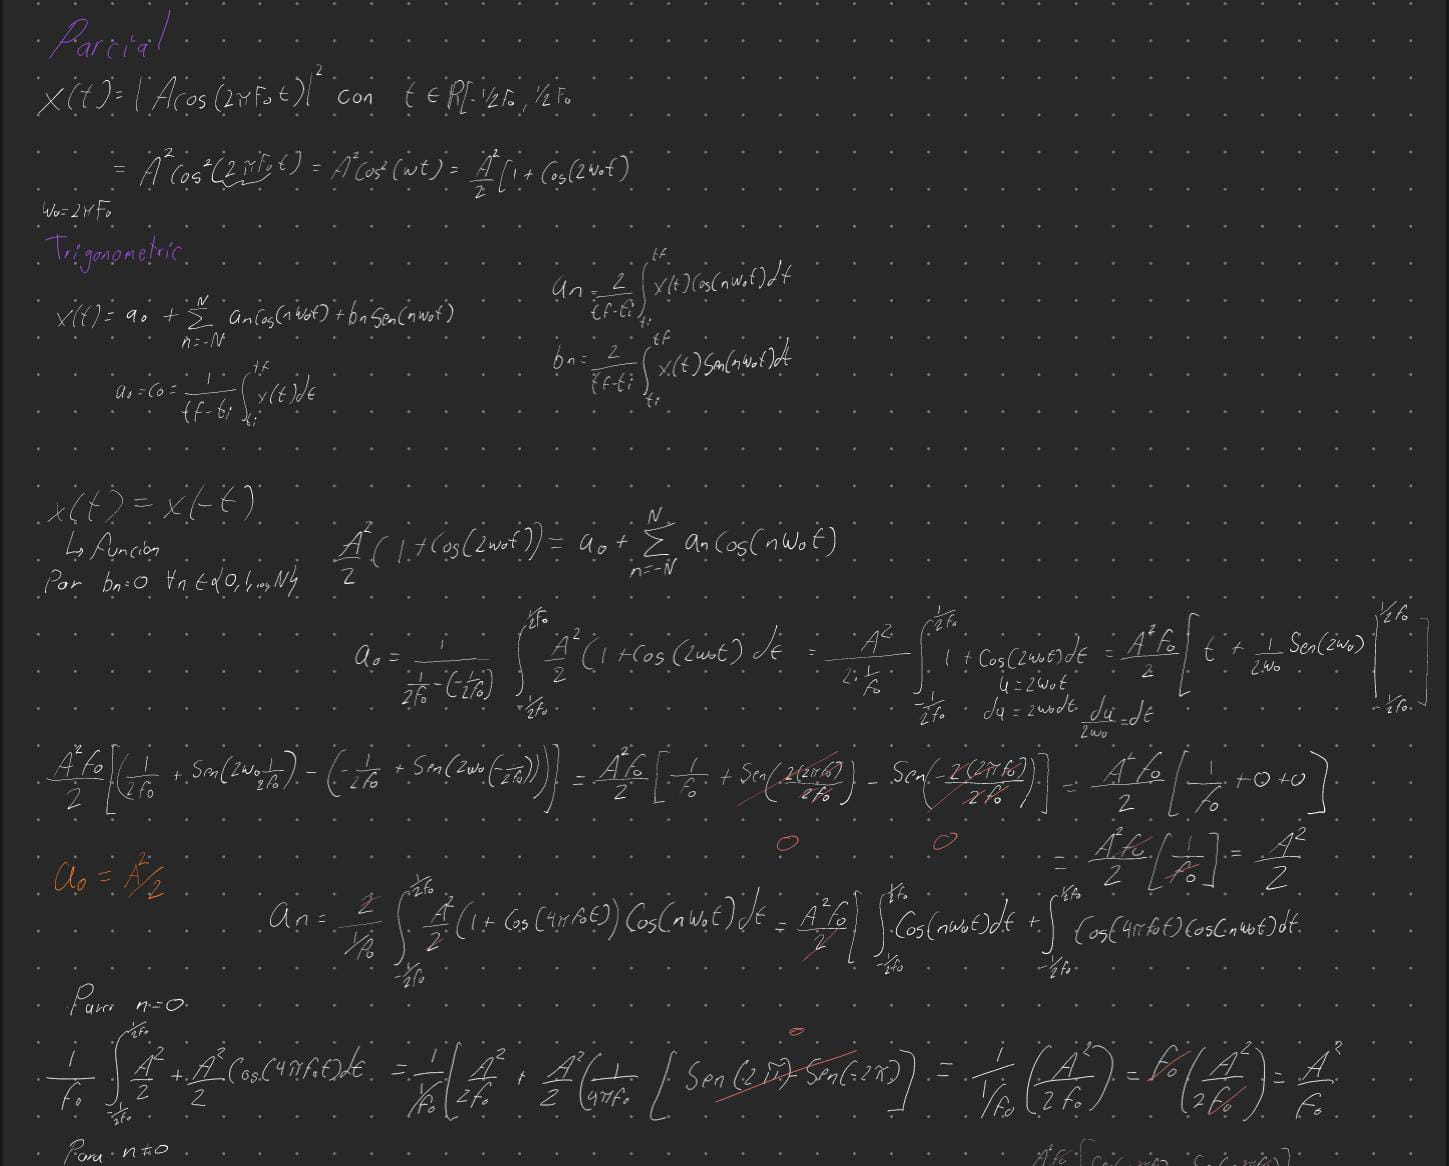

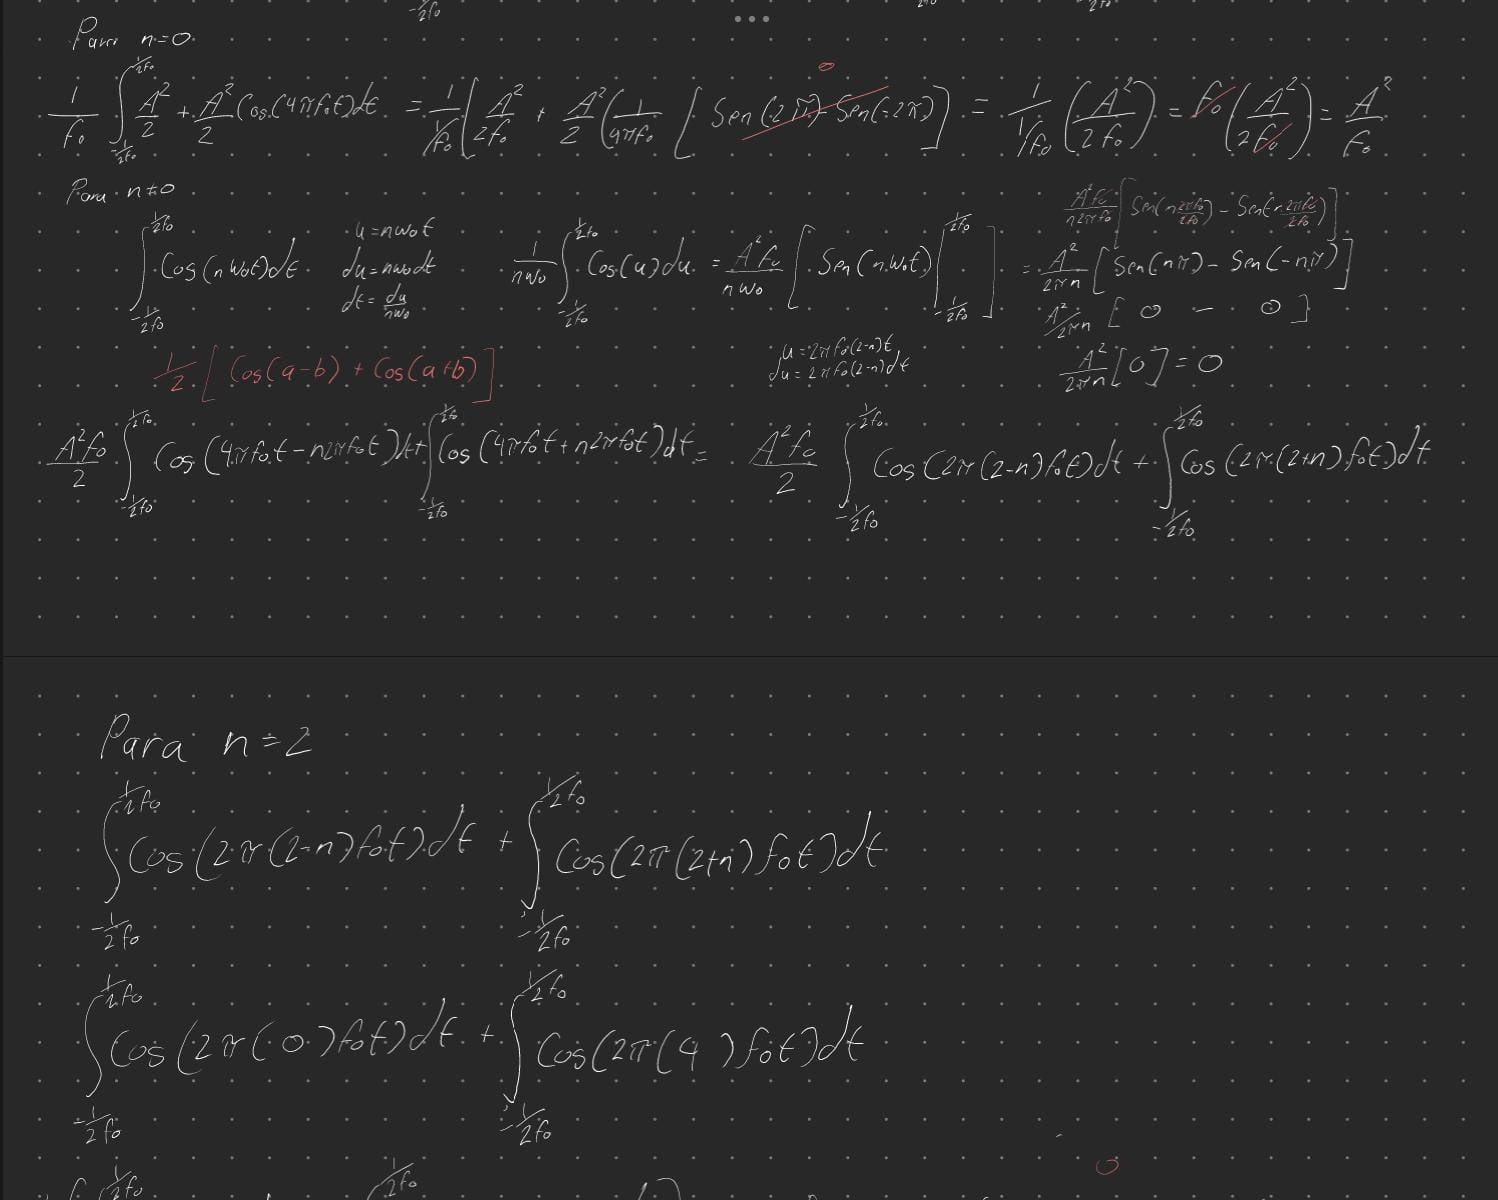

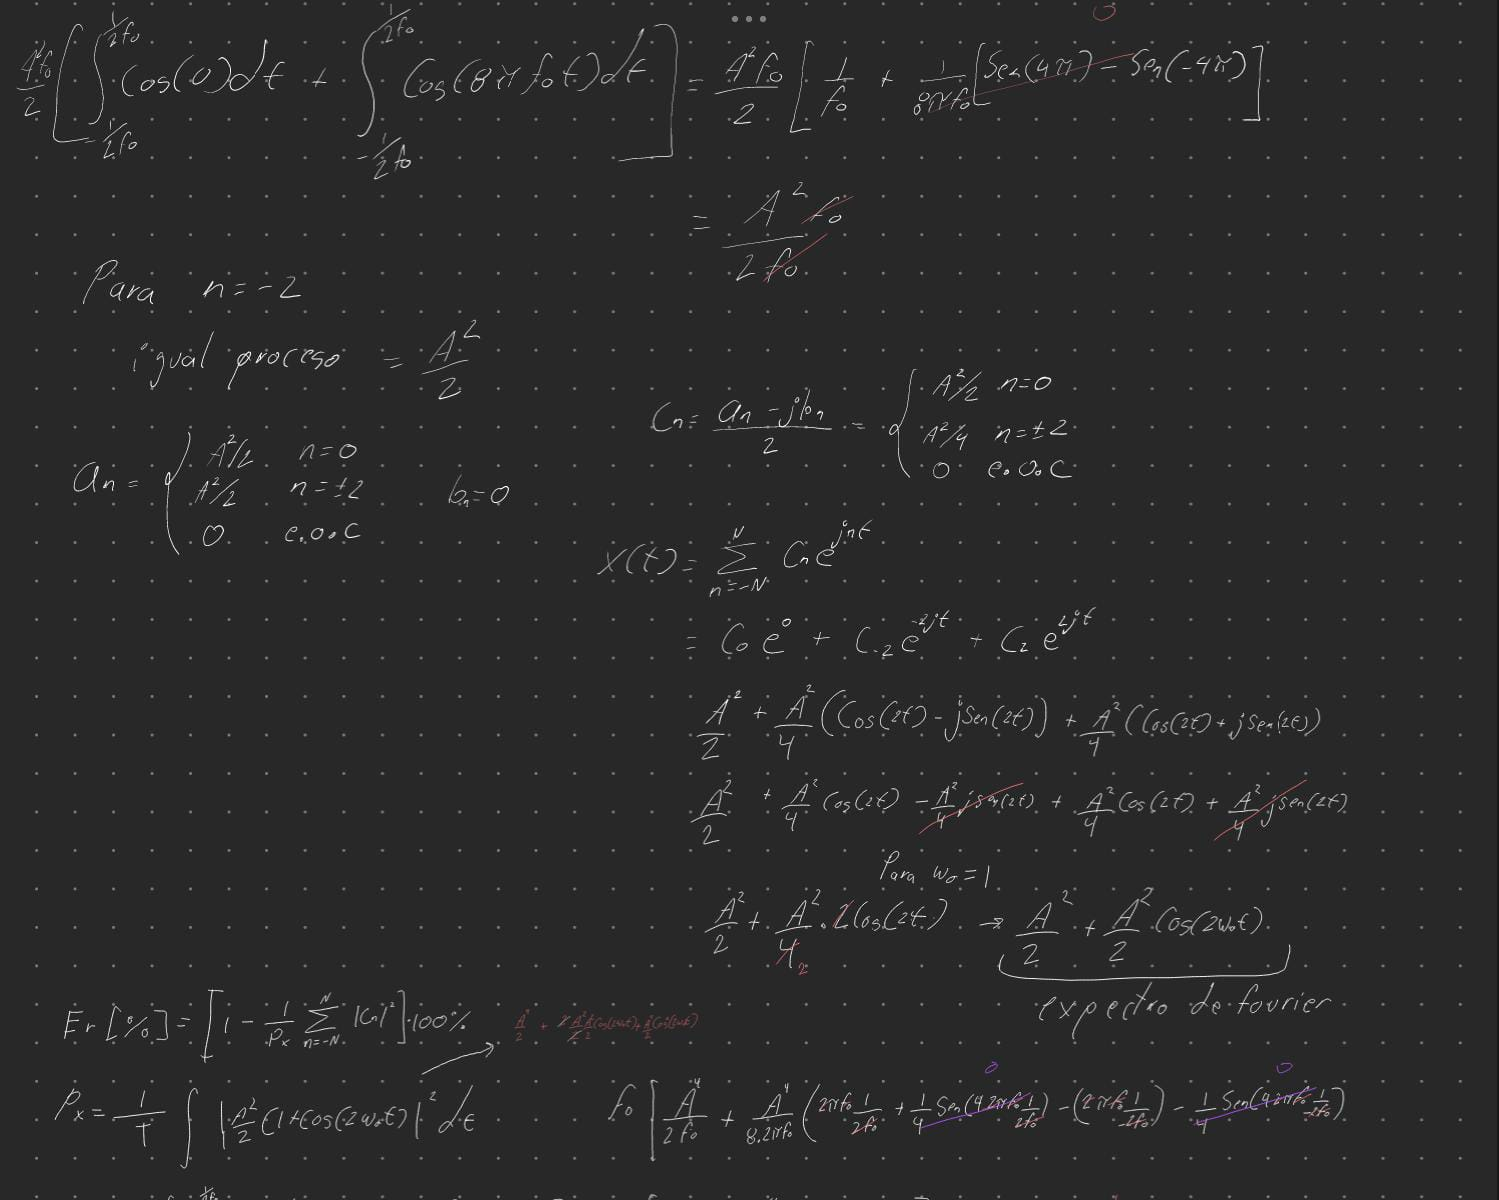

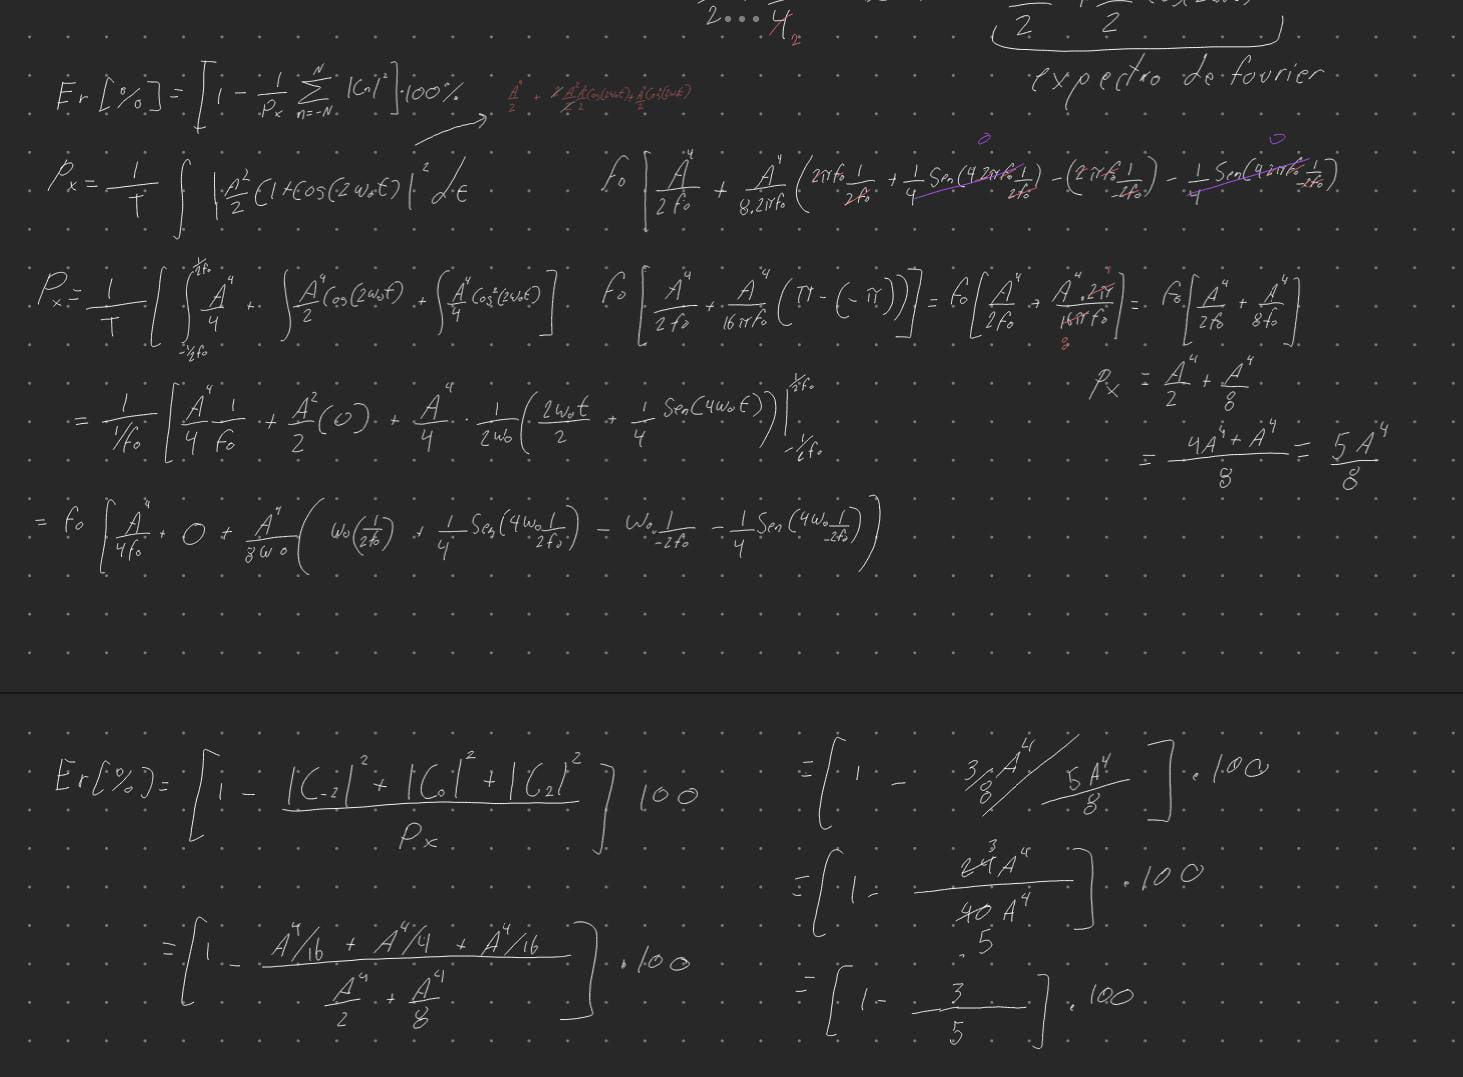

In [ ]:

import gdown

from pydub import AudioSegment
from IPython.display import Audio

%matplotlib inline
import matplotlib as mpl
import warnings
import streamlit as st
import pandas as pd
import numpy as np
import os
import subprocess
import soundfile as sf
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE
import joblib
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
import librosa
import librosa.display
from scipy.spatial.distance import euclidean
warnings.filterwarnings("ignore")

!pip install streamlit pydub numpy scipy matplotlib -q
!npm install localtunnel

!pip install streamlit_option_menu

⠙⠹⠸⠼⠴⠦
up to date, audited 23 packages in 983ms
⠦
⠦3 packages are looking for funding
⠦  run `npm fund` for details
⠦
2 moderate severity vulnerabilities

To address all issues (including breaking changes), run:
  npm audit fix --force

Run `npm audit` for details.
⠧

# Señal en tiempo continuo

wo= 12.566370614359172
Fo= 2


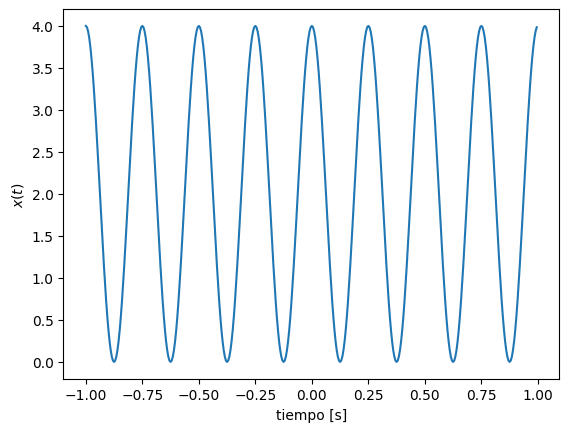

In [ ]:
A=2 # Amplitud señal x(t)
Fo=2 #frec fundamental (no la inventamos)

ti = -1/2*Fo #tiempo inicial
tf = 1/2*Fo #tiempo final
wo = 2*np.pi*Fo #frecuencia angular

print('wo=',wo)
print('Fo=',Fo)
Fs = 100*Fo #frecuencia muestreo -> debe respetar Nyquist Fs >= 2 Fo

tv = np.arange(ti,tf,1/Fs) #vector de tiempo

x = abs(A*np.cos(wo*tv))**2 #señal de entrada

plt.plot(tv,x) #gráfica de la señal
plt.xlabel('tiempo [s]')
plt.ylabel('$x(t)$')
plt.show()

# Bases de la serie exponencial

In [ ]:
#se crean las bases de la serie exponencial compleja de Fourier
T = tf - ti #intervalo de interés
N = 10 #número armonicos a simular

# definir bases
phin = np.zeros((len(tv),2*N+1),dtype=np.complex_)#crear matriz para guardar bases
for n in range(-N,N+1,1):
    phin[:,n+N] = np.exp(1j*n*wo*tv)#base de fourier en el intervalo de interés

# graficar bases
from ipywidgets import interact,IntSlider

def pltbase(n=1):
    plt.plot(tv,np.real(phin[:,int(n+N)]),label="Re{$\phi_n$(t)}")
    plt.xlabel("t[s]",fontsize = 14)
    plt.ylabel("$\phi_n$(t)",fontsize = 14)
    plt.plot(tv,np.imag(phin[:,int(n+N)]),label="Im{$\phi_n$(t)}")
    plt.grid()
    plt.legend()
    plt.show()
    return
interact(pltbase,n=(-N,N,1))

interactive(children=(IntSlider(value=1, description='n', max=10, min=-10), Output()), _dom_classes=('widget-i…

<function __main__.pltbase(n=1)>

# Graficadora del espectro en el tiempo

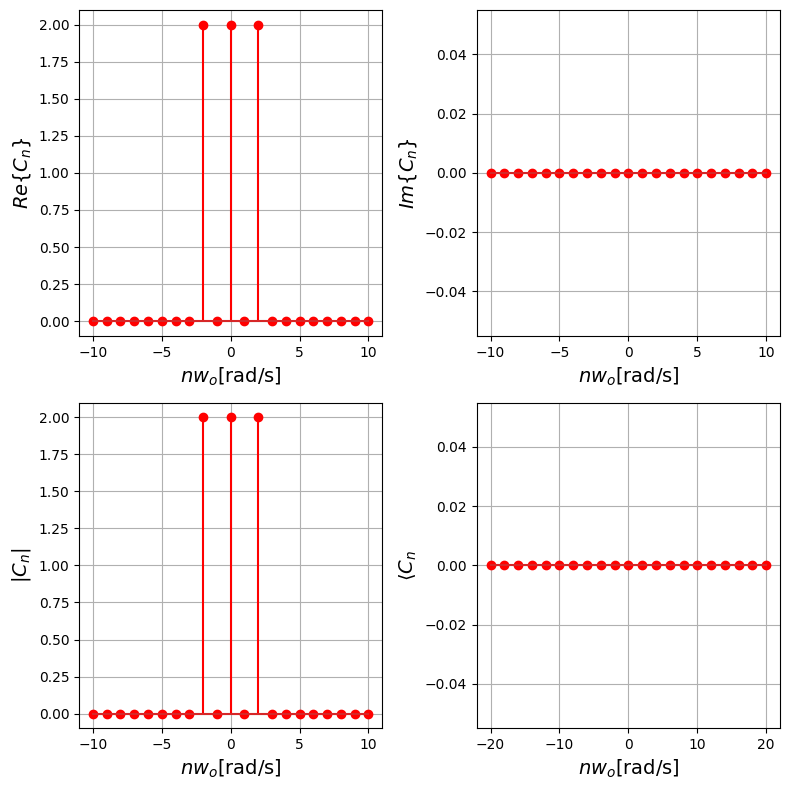

In [ ]:
#calcular espectro -> cambiar según la señal estudiada
cn = np.zeros(2*N+1,dtype=np.complex_)
nv = np.linspace(-N, N, 2*N+1) #vector armónicos
cn[N] = (A**2)/2 # nivel dc C_0
cn[N-2] = (A**2)/2 #armónico -6
cn[N+2] = (A**2)/2 #armónico +6

fr=np.arange(-N,N+1)*Fo #por que?
phi=np.angle(cn)
mg_db=10*np.log10(abs(cn))

#graficar espectro
fig = plt.figure(figsize=(8,8))
plt.subplot(2,2,1)
plt.stem(nv, np.real(cn), 'r')
plt.xlabel(r'$nw_o$[rad/s]',fontsize = 14)
plt.ylabel(r'$Re\{C_n\}$',fontsize = 14)
plt.axis('tight')
plt.grid()

plt.subplot(2,2,2)
plt.stem(nv, np.imag(cn), 'r')
plt.xlabel(r'$nw_o$[rad/s]',fontsize = 14)
plt.ylabel(r'$Im\{C_n\}$',fontsize = 14)
plt.axis('tight')
plt.grid()

plt.subplot(2,2,3)
plt.stem(nv, abs(cn), 'r')#magnitud del espectro
plt.xlabel(r'$nw_o$[rad/s]',fontsize = 14)
plt.ylabel(r'$|C_n|$',fontsize = 14)
plt.axis('tight')
plt.grid()

plt.subplot(2,2,4)
plt.stem(fr, phi,'r')#fase del espectro
plt.xlabel(r'$nw_o$[rad/s]',fontsize = 14)
plt.ylabel(r'$\langle C_n$',fontsize = 14)
plt.axis('tight')
plt.grid()


fig.tight_layout()
plt.show()

# Graficadora en el espectro de dB

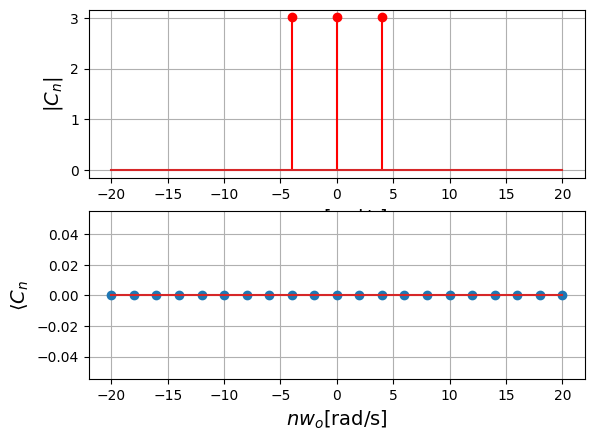

In [ ]:
plt.subplot(2,1,1)
plt.stem(fr, mg_db, 'r')#magnitud del espectro
plt.xlabel(r'$nw_o$[rad/s]',fontsize = 14)
plt.ylabel(r'$|C_n|$',fontsize = 14)
plt.axis('tight')
plt.grid()

plt.subplot(2,1,2)
plt.stem(fr, phi)#fase del espectro
plt.xlabel(r'$nw_o$[rad/s]',fontsize = 14)
plt.ylabel(r'$\langle C_n$',fontsize = 14)
plt.axis('tight')
plt.grid()


fig.tight_layout()
plt.show()

In [ ]:
Px = ((A**4)/2)+((A**4)/8) # estimar según señal estudiada
def pltest(Na=1):
    ind = np.arange(N-Na,N+Na+1)
    er = 1- np.sum(abs(cn[ind])**2)/Px
    #señal reconstruida
    xe=phin[:,ind].dot(cn[ind] ) # dot calcula el producto entre vectores
    plt.plot(tv,xe,color='b',label='$x_e(t)$') # señal estimada o filtrada
    plt.plot(tv,x,color='r',label='x(t)') #señal original
    plt.title('$E_r$=%.2f[%%]' % (100*er),fontsize=16)
    plt.xlabel('t[s]')
    plt.ylabel('x(t)')
    plt.grid()
    plt.legend()
    plt.show()

    return
interact(pltest,Na=(1,N,1))

interactive(children=(IntSlider(value=1, description='Na', max=10, min=1), Output()), _dom_classes=('widget-in…

<function __main__.pltest(Na=1)>

# Punto 2


2. Sea la señal portadora $c(t) = Ac sin(2πFct)$, con $Ac,Fc ∈ R$, y la señal mensaje $m(t) ∈ R$. Encuentre el espectro en frecuencia
 de la señal modulada en amplitud (AM), $y(t) = (1 + \frac{m(t)}{Ac})*c(t)$. Luego, descargue desde youtube 5 segundos de su cancion favorita (capturando del segundo 20 al 25). Presente una simulacion de modulacion por amplitud AM (tomando como mensaje el fragmento de la cancion escogida). Grafique las señales en tiempo y frecuencia (magnitud y fase) de la señal mensaje, portadora
 y modulada. Reproduzca los fragmentos de audio del mensaje, portadora y señal modulada. Nota: se sugiere utilizar un canal de señal de audio para el desarrollo del ejercicio. El usuario debe poder escoger el indice de modulacion deseado.

La transformada de Fourier de la señal modulada se puede encontrar como:

$$Y(\omega) = \mathcal{F}\{y(t)\} = \mathcal{F}\left\{\left(1+\frac{m(t)}{A_c}\right)c(t)\right\}=\mathcal{F}\{c(t)\}+\frac{1}{A_c}\mathcal{F}\{m(t)c(t)\}$$

En este caso (utilizando tablas de Fourier):

$$C(\omega) = \mathcal{F}\{c(t)\} = \mathcal{F}\{A_c\sin(2\pi F_c t)\} = A_c\mathcal{F}\left\{\frac{e^{2\pi F_ct}-e^{-2\pi F_ct}}{2j}\right\}$$

y

$$\mathcal{F\{e^{\pm j\omega_0 t}\}} = 2\pi\delta(\omega \mp \omega_0)$$

Por consiguiente:

$$\boxed{C(\omega) = \frac{A_c\pi}{j}(\delta(\omega - 2\pi F_c)-\delta(\omega + 2\pi F_c))}$$

De forma similar:

$$\frac{1}{A_c}\mathcal{F}\{m(t)c(t)\} = \frac{1}{A_c}\mathcal{F}\{m(t)A_c\sin(2\pi F_c t)\} = \mathcal{F}\{m(t)\sin(2\pi F_c t)\} = \mathcal{F}\left\{\frac{m(t)e^{2\pi F_ct}-m(t)e^{-2\pi F_ct}}{2j}\right\}$$

teniendo en cuenta que:

$$\mathcal{F}\{x(t)e^{\pm j\omega_0t}\} = X(\omega \mp \omega_0)$$


Entonces:

$$\boxed{\frac{1}{A_c}\mathcal{F}\{m(t)c(t)\} = \frac{1}{2j}\left(M(\omega - 2\pi F_c)-M(\omega + 2\pi F_c)\right)}$$


Finalmente, el espectro de la señal modulada se puede escribir como:

$$\boxed{Y(\omega) = \frac{A_c\pi}{j}(\delta(\omega - 2\pi F_c)-\delta(\omega + 2\pi F_c)) + \frac{1}{2j}\left(M(\omega - 2\pi F_c)-M(\omega + 2\pi F_c)\right)}$$

In [ ]:
!pip install pydub
!apt-get install ffmpeg
!pip install soundfile
!pip install pydub numpy scipy


import soundfile as sf # para instalar pip install soundfile
import matplotlib.pyplot as plt
import numpy as np


from IPython.display import Audio
#from scipy.signal import spectrogram
from google.colab import files
from pydub import AudioSegment
from scipy.io import wavfile
from IPython.display import Audio

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 18 not upgraded.


In [ ]:
# Función para cargar y convertir MP3 a WAV
def convert_mp3_to_wav(mp3_files):
    for mp3_file in mp3_files:
        # Cargar el archivo MP3
        audio = AudioSegment.from_mp3(mp3_file)
        # Convertir y guardar como WAV
        wav_file = mp3_file.replace('.mp3', '.wav')
        audio.export(wav_file, format='wav')
        print(f"Convertido: {mp3_file} a {wav_file}")

# Cargar archivos MP3
uploaded = files.upload()

# Filtrar los archivos MP3
mp3_files = [filename for filename in uploaded.keys() if filename.endswith('.mp3')]

convert_mp3_to_wav(mp3_files)



KeyboardInterrupt: 

In [ ]:
nombre_out = "Jungle.wav"
x, fs = sf.read(nombre_out)
# read speech signal from file
print('Frecuencia de muestreo %.2f[Hz]\naudio %s' % (fs,nombre_out))

In [ ]:
x.shape

In [ ]:
xpro = x.copy() #copiar archivos para procesar
#leer 5 segundos de la canción
ti = 65 #tiempo incio a procesar seg
tf = 70 #tiempo final a procesar seg
m = xpro[int(ti*fs):int((tf*fs)),0] #señal mensaje en primer canal
Audio(m,rate=fs)

In [ ]:
ns = 30 #se reproducen los primeros ns segundos
Audio(x[:int(fs*ns),:].T,rate=fs)

In [ ]:
#Señal mensaje en tiempo y frecuencia
tt = np.arange(ti,tf,1/fs) # vector de tiempo
plt.plot(tt,m,'r') #graficar señal mensaje en el tiempo
plt.xlabel('$tiempo [s]$')
plt.ylabel('$m(t)$')
plt.legend()
plt.show()

In [ ]:
#Fourier señal mensaje
Mw = np.fft.rfft(m) # axis=0 permite aplicar fft por cada columna de xpro
vf = np.fft.rfftfreq(m.shape[0],1/fs) #se crea el vector de frecuencias
plt.plot(vf,abs(Mw))#se grafica la magnitud
plt.title(r'Espectro señal mensaje')
plt.xlabel(r'$f[Hz]$',fontsize = 14)
plt.ylabel(r'$|M[f]|$',fontsize = 14)
plt.show()

plt.plot(vf, np.angle(Mw))#fase del espectro
plt.xlabel(r'$f[Hz]$',fontsize = 14)
plt.ylabel(r'$<M[f]$',fontsize = 14)
plt.show()

In [ ]:
Fc = 15000 #frecuencia portadora
Im = 0.5 # Im = peak(m(t))/Ac ->  Ac = peak(m(t))/Im
Ac = max(abs(m))/Im #amplitud de la portadora según índice de modulación
c = Ac*np.sin(2*np.pi*Fc*tt) #portadora

In [ ]:
#repoducir portadora
Audio(c,rate=fs)

In [ ]:
#Señal portadora en tiempo y frecuencia
plt.plot(tt,c) #graficar señal mensaje en el tiempo
plt.xlabel('$tiempo [s]$')
plt.ylabel('$c(t)$')
plt.show()

In [ ]:
#Fourier señal portadora
Cw = np.fft.rfft(c) # axis=0 permite aplicar fft por cada columna de xpro
plt.plot(vf,abs(Cw))#se grafica la magnitud
plt.title(r'Espectro Portadora')
plt.xlabel(r'$f[Hz]$',fontsize = 14)
plt.ylabel(r'$|C[f]|$',fontsize = 14)
plt.show()


plt.plot(vf, np.angle(Cw))#fase del espectro
plt.xlabel(r'$f[Hz]$',fontsize = 14)
plt.ylabel(r'$<C[f]$',fontsize = 14)
plt.show()

In [ ]:
#señal modulada
y = (1+m/Ac)*c #señal modulada en AM

In [ ]:
#repoducir modulada
Audio(y,rate=fs)

In [ ]:
plt.plot(tt,y) #graficar señal mensaje en el tiempo
plt.xlabel('$tiempo [s]$')
plt.ylabel('$y(t)$')
plt.show()

In [ ]:
#Fourier señal modulada
Yw = np.fft.rfft(y) # axis=0 permite aplicar fft por cada columna de xpro
plt.plot(vf,abs(Yw))#se grafica la magnitud
plt.title(r'Espectro modulada')
plt.xlabel(r'$f[Hz]$',fontsize = 14)
plt.ylabel(r'$|Y[f]|$',fontsize = 14)
plt.show()


plt.plot(vf, np.angle(Yw))#fase del espectro
plt.xlabel(r'$f[Hz]$',fontsize = 14)
plt.ylabel(r'$<Y[f]$',fontsize = 14)
plt.show()

#Punto 3

Ingrese el valor de R deseado:5
Ingrese el valor de C deseado:6
THD para carga resistiva pura: 3418.7258
THD para carga RC: 64.4389


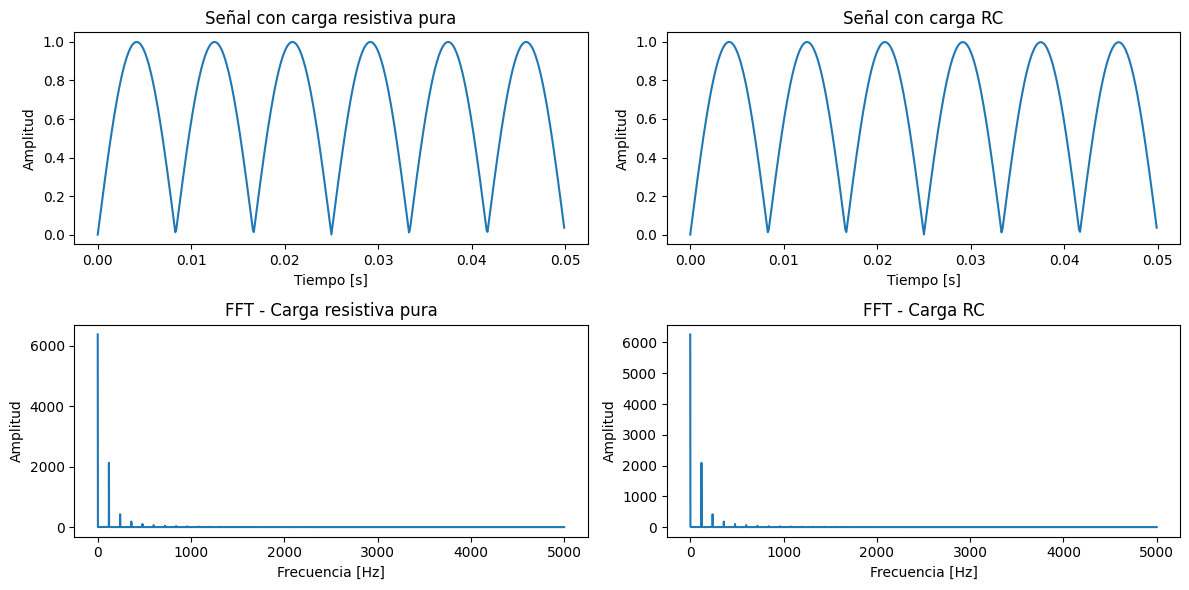

In [ ]:
from scipy.fft import fft, fftfreq

# Parámetros del sistema
sampling_rate = 10000  # Frecuencia de muestreo
T = 1.0 / sampling_rate  # Intervalo de tiempo
t = np.linspace(0, 1.0, sampling_rate)


# Generar señal del rectificador de onda completa
def rectificador_onda_completa(t, f, R, C=None):
    # Onda senoidal fundamental
    signal = np.abs(np.sin(2 * np.pi * f * t))

    if C is not None:
        # Respuesta para carga RC
        tau = R * C
        signal = signal * np.exp(-t / tau)

    return signal


# Calcular la FFT y los armónicos
def calcular_fft(signal, sampling_rate):
    N = len(signal)
    yf = fft(signal)
    xf = fftfreq(N, 1 / sampling_rate)[:N // 2]
    return xf, np.abs(yf[:N // 2])

# Calcular THD
def calcular_thd(yf):
    V1 = yf[1]  # El primer armónico
    harmonics = np.sqrt(np.sum(yf[2:]**2))
    thd = harmonics / V1
    return thd


# Parámetros de la simulación
f = 60  # Frecuencia de la señal de entrada (50 Hz)
R = float(input("Ingrese el valor de R deseado:"))  # Valor de la resistencia (ohmios)
C = float(input("Ingrese el valor de C deseado:"))  # Valor del condensador (faradios)

# Simulación para carga resistiva pura
signal_resistiva = rectificador_onda_completa(t, f, R)

# Simulación para carga RC en serie
signal_rc = rectificador_onda_completa(t, f, R, C)

# FFT de ambas señales
xf_res, yf_res = calcular_fft(signal_resistiva, sampling_rate)
xf_rc, yf_rc = calcular_fft(signal_rc, sampling_rate)

# Calcular THD
thd_resistiva = calcular_thd(yf_res)
thd_rc = calcular_thd(yf_rc)

print(f"THD para carga resistiva pura: {thd_resistiva:.4f}")
print(f"THD para carga RC: {thd_rc:.4f}")



# Graficar señales y su espectro
plt.figure(figsize=(12, 6))

# Señal en el dominio del tiempo
plt.subplot(2, 2, 1)
plt.plot(t[:500], signal_resistiva[:500])
plt.title("Señal con carga resistiva pura")
plt.xlabel("Tiempo [s]")
plt.ylabel("Amplitud")

plt.subplot(2, 2, 2)
plt.plot(t[:500], signal_rc[:500])
plt.title("Señal con carga RC")
plt.xlabel("Tiempo [s]")
plt.ylabel("Amplitud")

# FFT de las señales
plt.subplot(2, 2, 3)
plt.plot(xf_res, yf_res)
plt.title("FFT - Carga resistiva pura")
plt.xlabel("Frecuencia [Hz]")
plt.ylabel("Amplitud")

plt.subplot(2, 2, 4)
plt.plot(xf_rc, yf_rc)
plt.title("FFT - Carga RC")
plt.xlabel("Frecuencia [Hz]")
plt.ylabel("Amplitud")

plt.tight_layout()
plt.show()

### Punto 4


In [ ]:



!pip install streamlit pydub numpy scipy matplotlib -q
!npm install localtunnel

!pip install streamlit_option_menu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 95.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 88.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 6.3 MB/s eta 0:00:00
⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇
added 22 packages in 2s
⠇
⠇3 packages are looking for funding
⠇  run `npm fund` for details
⠇Collecting streamlit_option_menu
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 829.3/829.3 kB 37.4 MB/s eta 0:00:00


# Punto 4


In [ ]:
# enlace de google drive con audio
file_id = "1CWE5oDNxl_t04UX4i0YJIR90G9ZKl5Jp"  # ID de archivo

file2_id="14ZtB_RI3-kEm1HaEPck2MesbkKfl0Hxk"
url = f"https://drive.google.com/uc?id={file_id}"

url2=f"https://drive.google.com/uc?id={file2_id}"
output = "audios.zip"  # Nombre del archivo descargado
excel_path = 'base'



# Descargar el archivo desde Google Drive
gdown.download(url, output, quiet=False)

gdown.download(url2, excel_path, quiet=False)
# Descomprimir el archivo si es necesario

!unzip -o audios.zip -d audios

# Listar los archivos descargados
audio_files = os.listdir("audios")
print(audio_files)
print("Archivos de audio descargados:", audio_files)

wav_files = []

# Convertir MP3 a WAV y mostrar
for file in audio_files:
    if file.endswith(".mp3"):
        mp3_path = os.path.join("audios", file)
        wav_path = os.path.join("audios", file.replace(".mp3", ".wav"))

        wav_files.append(wav_path)

        audio = AudioSegment.from_mp3(mp3_path)

        audio.export(wav_path, format="wav")

        print(f"Mostrando: {wav_path}")
        display(Audio(wav_path, autoplay=False))

In [ ]:
path = 'audios/'
wav_files = [f for f in os.listdir(path) if f.endswith('.wav')]
wav_files

In [ ]:
# Cargar el archivo Excel (asegúrate de cambiar 'datos.xlsx' por tu nombre de archivo)

df = pd.read_excel(excel_path)
print(df.columns)
# Obtener los nombres de los archivos sin la ruta y extensión
wav_names = [os.path.basename(wav).replace(".wav", "") for wav in wav_files]

# Verificar coincidencias entre los nombres de los WAV y el Excel
for wav_name in wav_names:
    if wav_name in df["nombres"].values:  # Suponiendo que la columna se llama 'Nombre'
        row = df[df["nombres"] == wav_name]  # Obtener la fila correspondiente
        print(f"Audio: {wav_name} -> Valores en Excel: {row.to_dict(orient='records')}")
    else:
        print(f"Audio {wav_name} no encontrado en el Excel.")

In [ ]:
from scipy.io import wavfile
import soundfile as sf

fs = 48000
tl = np.array([0]) #puntos lectura
ts = 2 #t segmento
Ns = len(wav_files)*len(tl) #cantidad segmentos
x_t = np.zeros((Ns,int(ts*fs),2)) #Ns segmentos, cantidad de muestras, 2 canales (stereo)
label = np.zeros((Ns,1))*len(tl) #vector tipo de genero
name_c = []
#leer archivos wav
print(name_c)

In [ ]:
i = 0
for name in wav_files:#lectura audio .wav
    x, fs = sf.read(path+name)

     # Leer archivo .wav
    x, fs = sf.read(os.path.join("audios", name))

    # Si el audio es mono (1D), convertirlo a estéreo (2D)
    if len(x.shape) == 1:
      x = np.stack([x, x], axis=-1)  # Duplica el canal mono en dos canales

    for ti in tl: #segmentos de tiempo
        x_t[i] = x[int(fs*ti):int(fs*(ti+ts)),:]
        label1= df['type'].tolist() #tipo de genero

        name_c += [name[:-6]]
        print(f"{i} lectura: {name}; segundo {ti}:{ti+ts}; type {label1[i]}")
        i+=1
x_t.shape

In [ ]:
#calculo de fourier
vf = np.fft.rfftfreq(x_t.shape[1],1/fs) #calculo vector de frecuencias
Xw = np.fft.rfft(x_t,axis=1).mean(axis=-1) #transformada rapida de Fourier para señal Real a lo largo del tiempo (axis=1) y se promedian los dos canales
Xw.shape

In [ ]:
#grafica tiempo y fourier
plt.plot(np.arange(0,ts,1/fs),x_t.mean(axis=-1).T) #se promedian los dos canales stereo
plt.xlabel('t[s]')
plt.ylabel('x(t)')
plt.show()

In [ ]:
plt.plot(vf,abs(Xw).T)
plt.xlabel('f[Hz]')
plt.ylabel('|X(f)|')
plt.show()

In [ ]:
from sklearn.preprocessing import MinMaxScaler
sca = MinMaxScaler()
Xw_ = sca.fit_transform(abs(Xw).T).T

plt.plot(vf,Xw_.T)
plt.xlabel('f[Hz]')
plt.ylabel('|X(f)|')
plt.show()

#en dB
plt.plot(vf,(20*np.log10(Xw_+1e-10)).T) # se suma 1e-10 para evitar discontinuidad del log
plt.xlabel('f[Hz]')
plt.ylabel('|X(f)| dB')
plt.show()

In [ ]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
#visualización de datos
perplexity_value = min(3, Xw_.shape[0] - 1)
red_ = TSNE(perplexity = perplexity_value,n_components=2,random_state=123,learning_rate='auto',init='pca')
#red_ = PCA(n_components=2,random_state=123)
fmax = 7000
X_2D = red_.fit_transform(Xw_[:,:fmax]) #se tiene en cuenta el espectro hasta fmax Hz

print(perplexity_value)

In [ ]:
#graficar separabilidad 2D
plt.scatter(X_2D[:,0],X_2D[:,1],c=label)
plt.colorbar()
plt.show()

color_ = ["r","r"]
#nombre cancion
plt.scatter(X_2D[:,0],X_2D[:,1],c=label,s=1)
for i, tex in enumerate(name_c):
    #print(f"{i} {tex}")
    plt.text(X_2D[i,0]*1.025,X_2D[i,1]*1.025, tex[:-2]+"_"+str(i), fontsize=6,color=color_[int(label[i]-1)])

#plt.colorbar()
plt.show()

In [ ]:
# Diccionario para almacenar los espectros junto con los nombres de archivos
espectros_dict = {}

# Cargar y procesar los audios
for nam in wav_files:
    x, sr = librosa.load(path + nam, sr=None)

    # Aplicar la DFT y obtener la magnitud
    espectro = np.abs(np.fft.rfft(x))

    # Guardar en el diccionario con el nombre del archivo como clave
    espectros_dict[nam] = espectro

# Lista de rutas a los audios (ya que wav_files ya las contiene, no es necesario crearlas de nuevo)
rutas_audios = wav_files

for nombre, espectro in espectros_dict.items():
    print(f"Archivo: {nombre}, Espectro: {espectro[:10]}")

In [ ]:
def procesar_audio(ruta_audio):
    audio, sr = librosa.load(ruta_audio, sr=None)
    # Aplicar la DFT
    espectro = np.fft.rfft(audio)
    return np.abs(espectro)  # Obtener la magnitud

# Lista de rutas a los audios

espectros = [procesar_audio(path+ruta) for ruta in wav_files]
print(espectros)

In [ ]:
# Función para cargar y convertir MP3 a WAV
def convert_mp3_to_wav(mp3_files):
    for mp3_file in mp3_files:
        # Cargar el archivo MP3
        audio = AudioSegment.from_mp3(mp3_file)
        # Convertir y guardar como WAV
        wav_file = mp3_file.replace('.mp3', '.wav')
        audio.export(wav_file, format='wav')
        print(f"Convertido: {mp3_file} a {wav_file}")

# Cargar archivos MP3
uploaded = files.upload()

# Filtrar los archivos MP3
mp3_files = [filename for filename in uploaded.keys() if filename.endswith('.mp3')]

a=convert_mp3_to_wav(mp3_files)

filename = list(uploaded.keys())[0]  # Nombre del primer archivo subido
filepath = os.path.join('/content/', filename)  # Ruta completa del archivo

print(f'Ruta del archivo: {filepath}')

espectro_nuevo=procesar_audio(filepath)

In [ ]:
from scipy.spatial.distance import euclidean

# Lista de espectros de los audios ya procesados

# Calcular la distancia mínima
distancia_minima = float('inf')  # Inicializar con un valor grande
indice_minimo = ""


for nombre, espectro in enumerate(espectros):

    min_size = min(len(espectro), len(espectro_nuevo))
    espectro = espectro[:min_size]
    espectro_nuevo = espectro_nuevo[:min_size]

    distancia = euclidean(espectro_nuevo, espectro)
    if distancia < distancia_minima:
        distancia_minima = distancia
        indice_minimo = nombre

print(f'Distancia mínima: {distancia_minima} (Audio más cercano: {indice_minimo})', )